In [ ]:
# !python3 -m clrs.examples.run --algorithms "bellman_ford"

2025-02-15 11:49:57.906678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739620197.915837   12672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739620197.918554   12672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 11:49:59.971705: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO:2025-02-15 11:49:59,981:jax._src.xla_bridge:945: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0215 11:49:59.981147 131401512719488 xla_bridge.py:945] Unable to initialize backend 'rocm': mo

In [1]:
import functools
import os
import shutil
from typing import Any, Dict, List, Optional

from absl import app
from absl import flags
from absl import logging
import clrs
import jax
import numpy as np
import requests
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import random

def visualize_graph_from_adjacency_matrix(adjacency_matrix, weight_matrix=None):
    """
    Visualizes a graph with explicit arrows and labeled edge weights (adjacent).

    Args:
        adjacency_matrix: Adjacency matrix (NumPy array).
        weight_matrix: Optional weight matrix (NumPy array).
    """

    adjacency_matrix = np.array(adjacency_matrix)
    if adjacency_matrix.shape[0] != adjacency_matrix.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    num_nodes = adjacency_matrix.shape[0]

    if weight_matrix is None:
        weight_matrix = np.ones_like(adjacency_matrix)
    else:
        weight_matrix = np.array(weight_matrix)
        if weight_matrix.shape != adjacency_matrix.shape:
            raise ValueError("Weight matrix must have the same dimensions.")

    directed_graph = nx.DiGraph()
    undirected_graph = nx.Graph()

    for i in range(num_nodes):
        directed_graph.add_node(i)
        undirected_graph.add_node(i)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                if adjacency_matrix[i, j] != 0:
                    weight = round(weight_matrix[i, j], 2)
                    if adjacency_matrix[j, i] != 0:
                        if i < j:
                            undirected_graph.add_edge(i, j, weight=weight)
                    else:
                        directed_graph.add_edge(i, j, weight=weight)

    pos = nx.spring_layout(undirected_graph)  # Layout based on undirected

    plt.figure(figsize=(8, 6))

    # Draw undirected edges (no arrows)
    nx.draw_networkx_edges(undirected_graph, pos, edge_color='gray', width=2, arrows=False)
    edge_labels_undirected = nx.get_edge_attributes(undirected_graph, 'weight')
    # Use label_pos and rotate for adjacent labels
    nx.draw_networkx_edge_labels(undirected_graph, pos, edge_labels=edge_labels_undirected,
                                 label_pos=0.3, rotate=True)

    # Draw directed edges with explicit arrows
    nx.draw_networkx_edges(directed_graph, pos, edge_color='black', width=1,
                           arrowstyle='->', arrowsize=15)
    edge_labels_directed = nx.get_edge_attributes(directed_graph, 'weight')
    # Use label_pos and rotate for adjacent labels
    nx.draw_networkx_edge_labels(directed_graph, pos, edge_labels=edge_labels_directed,
                                 label_pos=0.3, rotate=True)

    nx.draw_networkx_nodes(directed_graph, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_labels(directed_graph, pos)

    plt.title("Graph Visualization")
    plt.axis('off')
    plt.show()


NUM_SAMPLES = 1000
encode_hints = True
decode_hints = True

rng = np.random.RandomState(42)
rng_key = jax.random.PRNGKey(rng.randint(2**32))

# Create samplers
sampler, spec = clrs.build_sampler(
        "bellman_ford",
        seed=rng.randint(2**32),
        num_samples=NUM_SAMPLES,
        length=7,
        )

processor_factory = clrs.get_processor_factory(
    'triplet_gmpnn',
    use_ln=True,
    nb_triplet_fts=8,
    nb_heads=1,
    )
model_params = dict(
    processor_factory=processor_factory,
    hidden_dim=128,
    encode_hints=encode_hints,
    decode_hints=decode_hints,
    encoder_init='xavier_on_scalars',
    use_lstm=False,
    learning_rate=0.001,
    grad_clip_max_norm=1.0,
    checkpoint_path='checkpoints/CLRS30',
    freeze_processor=False,
    dropout_prob=0.0,
    hint_teacher_forcing=0.0,
    hint_repred_mode='soft',
    nb_msg_passing_steps=1,
    )
dummy_traj = [sampler.next()]
model = clrs.models.BaselineModel(
  spec=[spec],
  dummy_trajectory=dummy_traj,
    get_inter=True,
  **model_params
)

# feedback_list = [next(t) for t in train_samplers]

# # Initialize model.
all_features = [f.features for f in dummy_traj]
model.init(all_features, 43)

model.restore_model('best.pkl', only_load_processor=False)


feedback = sampler.next()
# batch_size = feedback.outputs[0].data.shape[0]
new_rng_key, rng_key = jax.random.split(rng_key)

preds, _, hist = model.predict(new_rng_key, feedback.features)


2025-02-23 20:38:34.053036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740343114.064627   10028 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740343114.067839   10028 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
feedback.outputs[0].data.shape

(1000, 7)

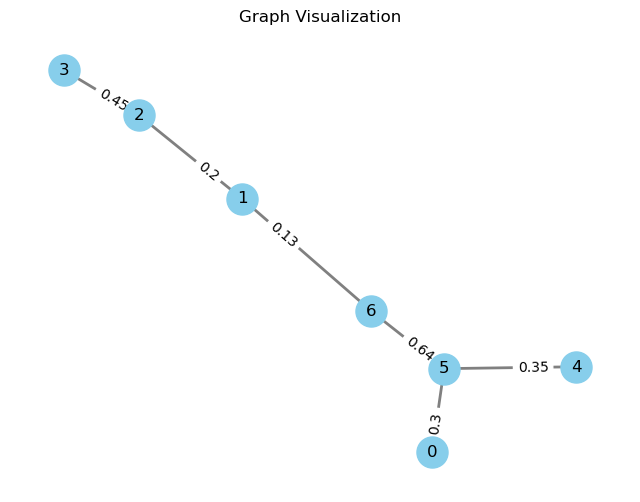

In [3]:
import random
item = random.randint(0, NUM_SAMPLES-1)
weights = feedback.features.inputs[2].data[item]
adj = feedback.features.inputs[3].data[item]
visualize_graph_from_adjacency_matrix(adj, weights)

In [3]:
preds['pi'].data[item]

Array([6., 3., 2., 5., 6., 6., 6.], dtype=float32)

In [4]:
feedback.outputs[0].data[item]

array([6, 3, 2, 5, 6, 6, 6])

In [5]:
gt_distances = feedback.features.hints[1].data[:,item,:]

In [6]:
hist[0].hiddens.shape

(1000, 7, 128)

In [11]:
len(hist)

7

In [9]:
hidden_states = np.stack([hist[i].hiddens[item] for i in range(7)])

In [10]:
hidden_states.shape

(7, 7, 128)

In [15]:
hidden_states[2]

array([[-5.57060470e-04, -4.42666678e-05, -1.04704932e-05,
        -3.75850250e-05,  4.79483128e-01, -2.50252366e-01,
        -3.70225207e-05,  5.41632287e-02, -6.05110581e-05,
        -3.17516953e-01, -5.64759597e-04, -3.03903071e-05,
        -2.89645941e-05,  3.39706707e+00, -7.52401352e-02,
        -2.08628444e-05,  1.93750274e+00,  5.02030075e-01,
         9.98109877e-02, -6.11152276e-02, -6.14503224e-05,
        -4.17179195e-04, -3.72906357e-01, -1.08084013e-03,
        -2.62076946e-06, -3.57461363e-01, -1.90890342e-01,
        -8.39518634e-06, -1.18387426e-04, -8.04630236e-06,
        -6.06710455e-05, -1.09281227e-05, -7.65131265e-02,
        -1.37300915e-04, -5.26535571e-01, -1.11410409e-01,
        -2.40803659e-01,  2.59074237e-04, -2.37633184e-01,
        -1.19179051e-04, -8.25755415e-04, -9.24350787e-03,
         2.06790471e+00, -1.84835858e-06, -5.93922473e-03,
        -1.76624280e-06,  1.60817027e+00, -3.06238770e-01,
         3.63948417e+00, -5.16292603e-05,  1.18955934e+0

In [28]:
pred_distances = np.stack([hist[i].hint_preds['d'][item] for i in range(6)])

In [29]:
pred_distances

array([[ 0.0181314 ,  0.02040932, -0.04741773,  0.02251913,  0.3484529 ,
         0.02420866,  0.02549018],
       [-0.01688743,  0.7240098 , -0.04077971,  0.64844507,  0.28606293,
        -0.01042079, -0.01252194],
       [-0.02653136,  0.7457953 , -0.05056605,  0.6698984 ,  0.3377769 ,
         0.9282364 , -0.00698071],
       [-0.0286141 ,  0.7400521 , -0.03928775,  0.661202  ,  0.29927325,
         0.9333077 ,  1.1851364 ],
       [ 1.904062  ,  0.7563996 , -0.04483517,  0.6747404 ,  0.32863095,
         0.92498463,  1.1660279 ],
       [ 1.8337085 ,  0.7490817 , -0.04533114,  0.6705845 ,  0.3092793 ,
         0.9339648 ,  1.1737171 ]], dtype=float32)

In [30]:
gt_distances

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.34155027,
        0.        , 0.        ],
       [0.        , 0.74841518, 0.        , 0.67207262, 0.34155027,
        0.        , 0.        ],
       [0.        , 0.74841518, 0.        , 0.67207262, 0.34155027,
        0.94396969, 0.        ],
       [0.        , 0.74841518, 0.        , 0.67207262, 0.34155027,
        0.94396969, 1.163387  ],
       [1.84615435, 0.74841518, 0.        , 0.67207262, 0.34155027,
        0.94396969, 1.163387  ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [18]:
feedback.outputs[0]

DataPoint(name="pi",	location=node,	type=pointer,	data=Array(1000, 7))